In [ ]:
pip install beautifulsoup4

In [ ]:
pip install -U emoji


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 36.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import os
import re
from bs4 import BeautifulSoup
import emoji
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers  import Bidirectional
import warnings

In [ ]:
data=pd.read_csv('medium_data.csv')
data.shape

(6508, 10)

In [ ]:
def text_preprocessing(text):
    text=BeautifulSoup(text,"html.parser").get_text()
    text=re.sub('[^A-Za-z\s]','',text)
    text = emoji.replace_emoji(text, replace='')
    text=text.replace(u'\xa0', ' ')
    text=text.replace(u'\u200a', ' ')
    text=text.strip()
    return text

data['title']=data['title'].apply(text_preprocessing)
print(data['title'].head(10))


<ipython-input-5-ac090e6fd76f>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text=BeautifulSoup(text,"html.parser").get_text()


0    A Beginners Guide to Word Embedding with Gensi...
1    Handson Graph Neural Networks with PyTorch  Py...
2                          How to Use ggplot in Python
3    Databricks How to Save Files in CSV on Your Lo...
4    A StepbyStep Implementation of Gradient Descen...
5      An Easy Introduction to SQL for Data Scientists
6                        Hypothesis testing visualized
7    Introduction to Latent Matrix Factorization Re...
8              Which  Candidate is the Best at Twitter
9             What if AI model understanding were easy
Name: title, dtype: object


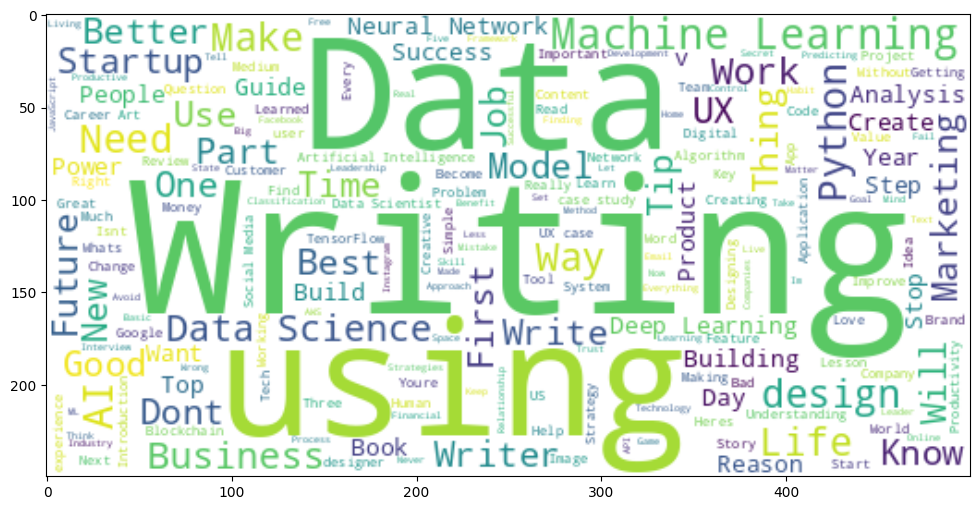

In [ ]:
from wordcloud import WordCloud
text=" ".join(title for title in data['title'])
wc=WordCloud(width=500,height=250,background_color='white').generate(text)
plt.figure(figsize=(12,6))
plt.imshow(wc,interpolation='bilinear')
plt.show()


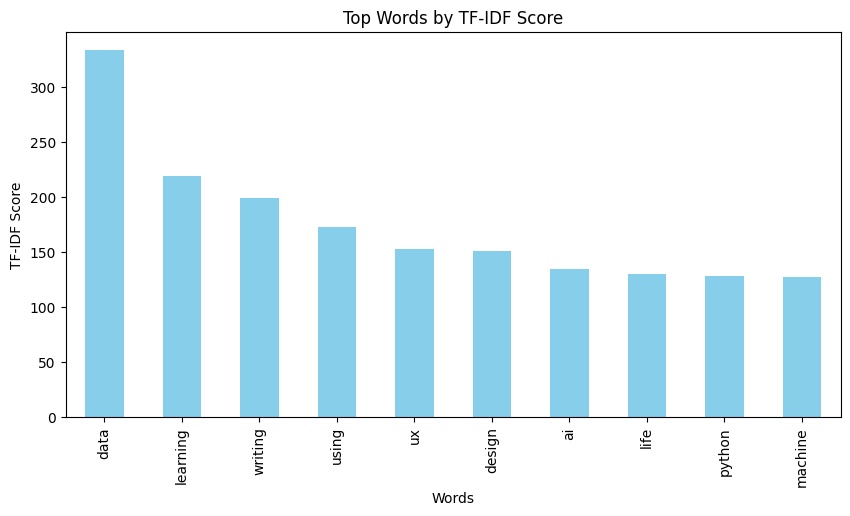

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english', max_features=10)
tfidf_matrix = tfidf.fit_transform(data['title'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
tfidf_df.sum().sort_values(ascending=False).plot(kind='bar', figsize=(10, 5), color='skyblue')
plt.title('Top Words by TF-IDF Score')
plt.xlabel('Words')
plt.ylabel('TF-IDF Score')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import os
import re
from bs4 import BeautifulSoup
import emoji
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score
from tensorflow.keras.layers  import Bidirectional
import warnings

data=pd.read_csv('medium_data.csv')
data.shape

def text_preprocessing(text):
    text=BeautifulSoup(text,"html.parser").get_text()
    text=re.sub('[^A-Za-z\s]','',text)
    text = emoji.replace_emoji(text, replace='')
    text=text.replace(u'\xa0', ' ')
    text=text.replace(u'\u200a', ' ')
    text=text.strip()
    return text

data['title']=data['title'].apply(text_preprocessing)
print(data['title'].head())



class Tokenizer:
    def fit_on_texts(self, texts):
        self.word_index = {}
        for text in texts:
            for word in text.split():
                if word not in self.word_index:
                    self.word_index[word] = len(self.word_index) + 1
        self.word_index["<PAD>"] = 0
        return self.word_index

    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            sequences.append([self.word_index.get(word, 0) for word in text.split()])
        return sequences


def text_generation(data_text):
    tkn = Tokenizer()
    tkn.fit_on_texts(data_text)
    total_wrds = len(tkn.word_index)
    seq_input = []
    for line in data_text:
        tkn_lst = tkn.texts_to_sequences([line])[0]
        for i in range(1, len(tkn_lst)):
            n_gram_sequence = tkn_lst[:i+1]
            seq_input.append(n_gram_sequence)
    return seq_input, total_wrds, tkn

seq_input, total_wrds, tkn = text_generation(data['title'])

max_sequence_len = max([len(x) for x in seq_input])
seq_input = np.array([np.pad(seq, (max_sequence_len - len(seq), 0), 'constant') for seq in seq_input])

X = seq_input[:, :-1]
y = seq_input[:, -1]

X = torch.tensor(X, dtype=torch.long)
y = torch.tensor(y, dtype=torch.long)

class TextGenerationModel(nn.Module):
    def __init__(self, total_wrds, embedding_dim, hidden_dim, max_sequence_len, dropout=0.3):
        super(TextGenerationModel, self).__init__()
        self.embedding = nn.Embedding(total_wrds, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True,
                            bidirectional=True, num_layers=2, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, total_wrds)

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]
        out = self.fc(lstm_out)
        return out


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on {device}")


X = X.to(device)
y = y.to(device)

model = TextGenerationModel(
    total_wrds,
    embedding_dim=150,
    hidden_dim=256,
    max_sequence_len=max_sequence_len - 1,
    dropout=0.5
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

batch_size = 512
num_epochs = 300

results = {'epoch': [], 'loss': [], 'accuracy': [], 'precision': [], 'recall': []}

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    epoch_preds = []
    epoch_labels = []

    for i in range(0, len(X), batch_size):
        X_batch = X[i:i+batch_size].to(device)
        y_batch = y[i:i+batch_size].to(device)

        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        _, predicted = torch.max(output, 1)
        epoch_preds.extend(predicted.cpu().numpy())
        epoch_labels.extend(y_batch.cpu().numpy())


    accuracy = np.mean(np.array(epoch_preds) == np.array(epoch_labels))
    precision = precision_score(epoch_labels, epoch_preds, average='micro', zero_division=0)
    recall = recall_score(epoch_labels, epoch_preds, average='micro', zero_division=0)

    scheduler.step(epoch_loss)


    results['epoch'].append(epoch + 1)
    results['loss'].append(epoch_loss / len(X))
    results['accuracy'].append(accuracy)
    results['precision'].append(precision)
    results['recall'].append(recall)


    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(X):.4f}, "f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

print("Training completed.")
print("Final Results:")
print(f"Loss: {results['loss'][-1]:.4f}")
print(f"Accuracy: {results['accuracy'][-1]:.4f}")
print(f"Precision: {results['precision'][-1]:.4f}")
print(f"Recall: {results['recall'][-1]:.4f}")



import matplotlib.pyplot as plt

def plot_metric(metric_name, metric_values):
    plt.figure(figsize=(10, 6))
    plt.plot(metric_values, label=f'Training {metric_name}', color='b')
    plt.xlabel("Epochs")
    plt.ylabel(metric_name.capitalize())
    plt.title(f'{metric_name.capitalize()} Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{metric_name}_plot.png")
    plt.close()

plot_metric("loss", results['loss'])
plot_metric("accuracy", results['accuracy'])
plot_metric("precision", results['precision'])
plot_metric("recall", results['recall'])

print("Plots saved as individual images for each metric.")




<ipython-input-9-6a414d174578>:22: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text=BeautifulSoup(text,"html.parser").get_text()


0    A Beginners Guide to Word Embedding with Gensi...
1    Handson Graph Neural Networks with PyTorch  Py...
2                          How to Use ggplot in Python
3    Databricks How to Save Files in CSV on Your Lo...
4    A StepbyStep Implementation of Gradient Descen...
Name: title, dtype: object
Training on cuda
Epoch 1/300, Loss: 0.0156, Accuracy: 0.0342, Precision: 0.0342, Recall: 0.0342
Epoch 2/300, Loss: 0.0144, Accuracy: 0.0504, Precision: 0.0504, Recall: 0.0504
Epoch 3/300, Loss: 0.0138, Accuracy: 0.0717, Precision: 0.0717, Recall: 0.0717
Epoch 4/300, Loss: 0.0130, Accuracy: 0.0853, Precision: 0.0853, Recall: 0.0853
Epoch 5/300, Loss: 0.0124, Accuracy: 0.0945, Precision: 0.0945, Recall: 0.0945
Epoch 6/300, Loss: 0.0118, Accuracy: 0.1034, Precision: 0.1034, Recall: 0.1034
Epoch 7/300, Loss: 0.0111, Accuracy: 0.1108, Precision: 0.1108, Recall: 0.1108
Epoch 8/300, Loss: 0.0106, Accuracy: 0.1217, Precision: 0.1217, Recall: 0.1217
Epoch 9/300, Loss: 0.0103, Accuracy: 0.1288, Prec

In [ ]:
def predict_next_words(model, tokenizer, input_texts, max_sequence_len):
    model.eval()

    predictions = []
    word_index = tokenizer.word_index
    index_word = {index: word for word, index in word_index.items()}

    for input_text in input_texts:

        input_sequence = tokenizer.texts_to_sequences([input_text])[0]
        input_sequence = np.pad(input_sequence, (max_sequence_len - len(input_sequence), 0), 'constant')
        input_sequence = torch.tensor(input_sequence, dtype=torch.long).unsqueeze(0).to(device)


        with torch.no_grad():
            output = model(input_sequence)
            predicted_index = torch.argmax(output, dim=1).item()

        predicted_word = index_word.get(predicted_index, "<UNK>")
        predictions.append(predicted_word)

    return predictions

input_texts = [
    "A Step-by-Step Implementation of",
    "An Introduction to Deep Learning and",
    "Exploring the Basics of Natural Language"
]

predicted_words = predict_next_words(model, tkn, input_texts, max_sequence_len - 1)

for input_text, predicted_word in zip(input_texts, predicted_words):
    print(f"Input: '{input_text}' -> Predicted next word: '{predicted_word}'")


Input: 'A Step-by-Step Implementation of' -> Predicted next word: 'Data'
Input: 'An Introduction to Deep Learning and' -> Predicted next word: 'Data'
Input: 'Exploring the Basics of Natural Language' -> Predicted next word: 'Processing'


In [ ]:
##### RNN IMPLEMENTATION

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re
import emoji
import pandas as pd


def text_preprocessing(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub('[^A-Za-z\s]', '', text)
    text = emoji.replace_emoji(text, replace='')
    text = text.replace(u'\xa0', ' ')
    text = text.replace(u'\u200a', ' ')
    text = text.strip()
    return text


data = pd.read_csv('medium_data.csv')
data['title'] = data['title'].apply(text_preprocessing)

class Tokenizer:
    def fit_on_texts(self, texts):
        self.word_index = {}
        for text in texts:
            for word in text.split():
                if word not in self.word_index:
                    self.word_index[word] = len(self.word_index) + 1
        self.word_index["<PAD>"] = 0
        return self.word_index

    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            sequences.append([self.word_index.get(word, 0) for word in text.split()])
        return sequences

def text_generation(data_text):
    tkn = Tokenizer()
    tkn.fit_on_texts(data_text)
    total_wrds = len(tkn.word_index)
    seq_input = []
    for line in data_text:
        tkn_lst = tkn.texts_to_sequences([line])[0]
        for i in range(1, len(tkn_lst)):
            n_gram_sequence = tkn_lst[:i+1]
            seq_input.append(n_gram_sequence)
    return seq_input, total_wrds, tkn

seq_input, total_wrds, tkn = text_generation(data['title'])
max_sequence_len = max([len(x) for x in seq_input])
seq_input = np.array([np.pad(seq, (max_sequence_len - len(seq), 0), 'constant') for seq in seq_input])

X = seq_input[:, :-1]
y = seq_input[:, -1]
X = torch.tensor(X, dtype=torch.long)
y = torch.tensor(y, dtype=torch.long)


class TextGenerationModel(nn.Module):
    def __init__(self, total_wrds, embedding_dim, hidden_dim, max_sequence_len, dropout=0.3):
        super(TextGenerationModel, self).__init__()
        self.embedding = nn.Embedding(total_wrds, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True,
                          bidirectional=True, num_layers=2, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, total_wrds)

    def forward(self, x):
        x = self.embedding(x)
        rnn_out, _ = self.rnn(x)
        rnn_out = rnn_out[:, -1, :]
        out = self.fc(rnn_out)
        return out


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X, y = X.to(device), y.to(device)

model = TextGenerationModel(
    total_wrds,
    embedding_dim=150,
    hidden_dim=256,
    max_sequence_len=max_sequence_len - 1,
    dropout=0.5
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

batch_size = 512
num_epochs = 200
results = {'epoch': [], 'loss': [], 'accuracy': [], 'precision': [], 'recall': []}

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    epoch_preds = []
    epoch_labels = []

    for i in range(0, len(X), batch_size):
        X_batch = X[i:i+batch_size]
        y_batch = y[i:i+batch_size]

        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(output, 1)
        epoch_preds.extend(predicted.cpu().numpy())
        epoch_labels.extend(y_batch.cpu().numpy())

    accuracy = np.mean(np.array(epoch_preds) == np.array(epoch_labels))
    precision = precision_score(epoch_labels, epoch_preds, average='micro', zero_division=0)
    recall = recall_score(epoch_labels, epoch_preds, average='micro', zero_division=0)
    scheduler.step(epoch_loss)

    results['epoch'].append(epoch + 1)
    results['loss'].append(epoch_loss / len(X))
    results['accuracy'].append(accuracy)
    results['precision'].append(precision)
    results['recall'].append(recall)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(X):.4f}, "f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

print("Training completed.")
print("Final Results:")
print(f"Loss: {results['loss'][-1]:.4f}")
print(f"Accuracy: {results['accuracy'][-1]:.4f}")
print(f"Precision: {results['precision'][-1]:.4f}")
print(f"Recall: {results['recall'][-1]:.4f}")


def plot_metric(metric_name, metric_values):
    plt.figure(figsize=(10, 6))
    plt.plot(metric_values, label=f'Training {metric_name}', color='b')
    plt.xlabel("Epochs")
    plt.ylabel(metric_name.capitalize())
    plt.title(f'{metric_name.capitalize()} Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"rnn_{metric_name}_plot.png")
    plt.close()

plot_metric("loss", results['loss'])
plot_metric("accuracy", results['accuracy'])
plot_metric("precision", results['precision'])
plot_metric("recall", results['recall'])

print("Plots saved as individual images for each metric.")


<ipython-input-11-eac18728e576>:14: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


Epoch 1/200, Loss: 0.0154, Accuracy: 0.0470, Precision: 0.0470, Recall: 0.0470
Epoch 2/200, Loss: 0.0135, Accuracy: 0.0808, Precision: 0.0808, Recall: 0.0808
Epoch 3/200, Loss: 0.0124, Accuracy: 0.0969, Precision: 0.0969, Recall: 0.0969
Epoch 4/200, Loss: 0.0114, Accuracy: 0.1110, Precision: 0.1110, Recall: 0.1110
Epoch 5/200, Loss: 0.0105, Accuracy: 0.1257, Precision: 0.1257, Recall: 0.1257
Epoch 6/200, Loss: 0.0096, Accuracy: 0.1468, Precision: 0.1468, Recall: 0.1468
Epoch 7/200, Loss: 0.0088, Accuracy: 0.1836, Precision: 0.1836, Recall: 0.1836
Epoch 8/200, Loss: 0.0083, Accuracy: 0.2165, Precision: 0.2165, Recall: 0.2165
Epoch 9/200, Loss: 0.0078, Accuracy: 0.2419, Precision: 0.2419, Recall: 0.2419
Epoch 10/200, Loss: 0.0072, Accuracy: 0.2826, Precision: 0.2826, Recall: 0.2826
Epoch 11/200, Loss: 0.0069, Accuracy: 0.2964, Precision: 0.2964, Recall: 0.2964
Epoch 12/200, Loss: 0.0067, Accuracy: 0.3079, Precision: 0.3079, Recall: 0.3079
Epoch 13/200, Loss: 0.0063, Accuracy: 0.3466, Pre

In [ ]:
def predict_next_words(model, tokenizer, input_texts, max_sequence_len):
    model.eval()

    predictions = []
    word_index = tokenizer.word_index
    index_word = {index: word for word, index in word_index.items()}

    for input_text in input_texts:

        input_sequence = tokenizer.texts_to_sequences([input_text])[0]
        input_sequence = np.pad(input_sequence, (max_sequence_len - len(input_sequence), 0), 'constant')
        input_sequence = torch.tensor(input_sequence, dtype=torch.long).unsqueeze(0).to(device)


        with torch.no_grad():
            output = model(input_sequence)
            predicted_index = torch.argmax(output, dim=1).item()

        predicted_word = index_word.get(predicted_index, "<UNK>")
        predictions.append(predicted_word)

    return predictions

input_texts = [
    " An Easy Introduction to SQL for Data Scientists",
                       "Hypothesis testing visualized","Introduction to Latent Matrix Factorization",


]

predicted_words = predict_next_words(model, tkn, input_texts, max_sequence_len - 1)

for input_text, predicted_word in zip(input_texts, predicted_words):
    print(f"Input: '{input_text}' -> Predicted next word: '{predicted_word}'")


Input: ' An Easy Introduction to SQL for Data Scientists' -> Predicted next word: 'Remastered'
Input: 'Hypothesis testing visualized' -> Predicted next word: 'in'
Input: 'Introduction to Latent Matrix Factorization' -> Predicted next word: 'Recommender'
